# **Install & Import Modules**

In [1]:
!pip install optuna catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import kagglehub
import os
import optuna

from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
)
from scipy.stats.mstats import winsorize
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

# **Download Data**

In [3]:
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stroke-prediction-dataset


# **Load Dataset**

In [8]:
full_path = os.path.join(path, "healthcare-dataset-stroke-data.csv")
df = pd.read_csv(full_path)

# **Data Preparation**

In [9]:
df_prep = df.copy()

## Drop Kolom yang Tidak Relevan (ID, Duplikat)

In [10]:
df_prep = df_prep.drop(columns=['id'])
df_prep = df_prep.drop_duplicates()

## Encoding Variabel Kategorikal

In [11]:
df_prep['gender'] = df_prep['gender'].apply(lambda x: 0 if x == 'Male' else 1 if x == "Female" else 2)
df_prep['ever_married'] = df_prep['ever_married'].apply(lambda x: 0 if x == 'Yes' else 1)
df_prep['Residence_type'] = df_prep['Residence_type'].apply(lambda x: 0 if x == 'Urban' else 1)

smoke_mapping = {
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2,
    'Unknown': 3
}
df_prep['smoking_status'] = df_prep['smoking_status'].map(smoke_mapping)
df_prep = pd.get_dummies(df_prep, columns=['work_type'], drop_first=True, prefix='work_type', dtype=int)

## Menangani Missing Values

In [12]:
imputer = KNNImputer(n_neighbors=5)
bmi_imputed = imputer.fit_transform(df_prep)
df_imputed = pd.DataFrame(bmi_imputed, columns=df_prep.columns)

## Menangani Outlier

In [13]:
con_columns = ['avg_glucose_level', 'bmi']
df_imputed[con_columns] = df_imputed[con_columns].apply(lambda x: winsorize(x, (0.05, 0.05)))

## Feature Engineering

In [14]:
df_imputed['age_group'] = pd.cut(
    df_imputed['age'],
    bins=[0, 30, 50, 100],
    labels=[0, 1, 2]
).astype(int)

df_imputed['glucose_bmi_interaction'] = (
    df_imputed['avg_glucose_level'] * df_imputed['bmi']
)
df_imputed['glucose_per_bmi'] = (
    df_imputed['avg_glucose_level'] / (df_imputed['bmi'] + 1e-3)
)

df_imputed['age_x_smoking'] = (
    df_imputed['age'] * df_imputed['smoking_status']
)

df_imputed['chronic_risk'] = (
    (df_imputed['hypertension'] == 1) &
    (df_imputed['heart_disease'] == 1)
).astype(int)

df_imputed['is_employed'] = (
    df_imputed['work_type_Private'] +
    df_imputed['work_type_Self-employed'] +
    df_imputed['work_type_Never_worked']
)

df_imputed['gender_hyper'] = (
    df_imputed['gender'] * df_imputed['hypertension']
)

## Split Data untuk Pelatihan dan Test


In [15]:
X = df_imputed.drop(columns=['stroke'])
y = df_imputed['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Modeling**

## Model Selection

In [16]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Catboost': CatBoostClassifier(verbose=0, random_state=42)
}

skf_non_umap = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_scores_non_umap = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf_non_umap, scoring='f1_macro')
    model_scores_non_umap[name] = np.mean(scores)
    print(f"{name}: F1-weighted Score = {model_scores_non_umap[name]:.4f}")

sorted_models_non_umap = sorted(model_scores_non_umap.items(), key=lambda x: x[1], reverse=True)

RandomForest: F1-weighted Score = 0.4873
DecisionTree: F1-weighted Score = 0.5382
XGBoost: F1-weighted Score = 0.5226
LightGBM: F1-weighted Score = 0.5064
Catboost: F1-weighted Score = 0.5044


## Hyperparamter Tuning pada Model Catboost

In [19]:
def objective(trial):
    """
    Fungsi objektif untuk Optuna dengan DecisionTreeClassifier
    """
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'random_state': 42,
    }

    model = DecisionTreeClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')

    return f1

In [20]:
study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100, timeout=3600)

[I 2025-05-29 16:12:43,549] A new study created in memory with name: no-name-b649061d-a932-4dd7-a5f8-88fbfc91fe93
[I 2025-05-29 16:12:43,619] Trial 0 finished with value: 0.526646403242148 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.526646403242148.
[I 2025-05-29 16:12:43,666] Trial 1 finished with value: 0.48746238716148443 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 0 with value: 0.526646403242148.
[I 2025-05-29 16:12:43,699] Trial 2 finished with value: 0.48746238716148443 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 0 with value: 0.526646403242148.
[I 2025-05-29 16:12:43,730] Trial 3 finished with value: 0.48746238716148443 and parameters: {'criterion': 'entropy', 'max_de

## Train Final Model

In [27]:
study.best_params

{'criterion': 'entropy',
 'max_depth': 14,
 'min_samples_split': 9,
 'min_samples_leaf': 7,
 'max_features': None}

In [21]:
model_dt = DecisionTreeClassifier(**study.best_params, random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=7,
                       min_samples_split=9, random_state=42)

# **Evaluasi**

In [22]:
y_pred = model_dt.predict(X_test)
y_proba = model_dt.predict_proba(X_test)[:, 1]

## Classification Report

In [23]:
print(classification_report(y_test, y_pred, target_names=["Non-Stroke", "Stroke"]))

              precision    recall  f1-score   support

  Non-Stroke       0.96      0.98      0.97       972
      Stroke       0.33      0.20      0.25        50

    accuracy                           0.94      1022
   macro avg       0.65      0.59      0.61      1022
weighted avg       0.93      0.94      0.93      1022



## Confusion Matrix

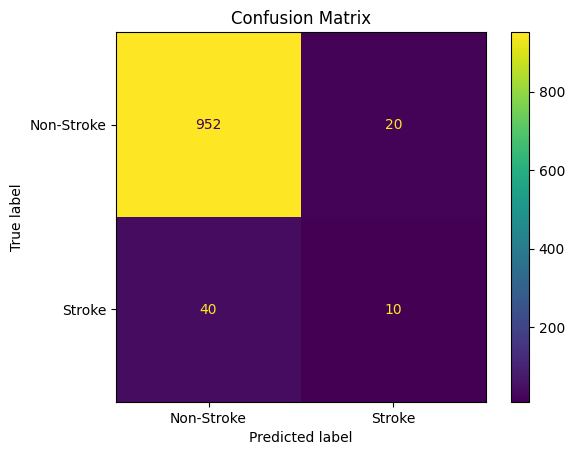

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Non-Stroke", "Stroke"])
plt.title("Confusion Matrix")
plt.show()

## Kurva ROC

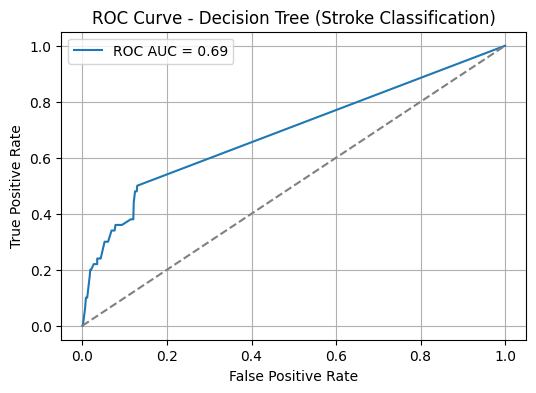

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Stroke Classification)')
plt.legend()
plt.grid()
plt.show()